# ВЫПОЛНИЛ АНДРЕЕВ ВЛАДИСЛАВ ВЛАДИМИРОВИЧ
# ГРУППА: НПМбд-01-20
# ЛАБОРАТОРНАЯ №1  
# ПОРТФЕЛИ МАРКОВИЦА И ТОБИНА


In [289]:
from scipy.optimize import linprog, minimize
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
import plotly_express as px

warnings.filterwarnings('ignore')

## Грузим базу данных с котировками

In [290]:
# читаем данные из эксель
df = pd.read_excel('stockdata.xlsx')
df = df.set_index('DATE')
df.head(10)

,LKOH,ARFLT,YNDX
DATE,,,
2022-04-25,4699.5,30.50,1766.6
2022-05-02,4635.5,32.14,1688.0
2022-05-09,4380.0,29.98,1593.0
2022-05-16,4279.0,29.28,1646.0
2022-05-23,4290.0,29.42,1644.0
2022-05-30,3980.5,28.76,1497.0
2022-06-06,3898.0,26.74,1400.8
2022-06-13,4182.0,26.30,1465.0
2022-06-20,4100.0,27.52,1645.0


## Изменение стоимости акций

In [291]:
#изменение от начальной точки периода
px.line(df/df.iloc[0])

## Доходность акций за период

In [292]:
changes = df.pct_change()
px.line(changes)

## Портфель Марковица наивысшей доходности


In [293]:
def MaximizeProfit(inbound):

    expected_value = inbound.mean()
    # среднее
    cov = inbound.cov()
    # ковариация
    n = len(expected_value)

    c = np.matrix(-1 * np.array(expected_value))
    A_eq = np.matrix(np.ones(n))
    b_eq = 1.
    # Решаем симплекс методом
    opt = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method='simplex')

    x = opt.x
    # формула для Rp
    r_p = x.dot(expected_value.T)
    sigm_p = np.sqrt(np.dot(np.dot(x, cov), x.T))

    return x, r_p, sigm_p

In [294]:
x, r_p, sigm_p = MaximizeProfit(changes)

index = np.arange(1, len(x) + 1)

data = {
        'Акция' : df.columns, 
        'E(R)' : changes.mean(), 
        'sigma(R)' : changes.std(),
        'Вес': x
        }

params = pd.DataFrame.from_dict(data).set_index(index)

figurePie = px.pie(params, values='Вес', names='Акция', title='Портфель максимальной доходности')
figurePie.update_traces(textposition='inside', textinfo='percent+label')
figurePie.show()

print(f'Доходность: {round(r_p * 100, 2)}%\nРиск: {round(sigm_p * 100, 2)}%')
params

Доходность: 0.6%
Риск: 4.14%


,Акция,E(R),sigma(R),Вес
1,LKOH,0.006009,0.041397,1.0
2,ARFLT,0.003654,0.041155,0.0
3,YNDX,0.005703,0.048042,0.0


## Портфель Марковица минимального риска без ограничений на эффективность




### Решаем Методом множителей Лагранжа




In [295]:
# функция возвращает матрицу лагранджа
def lagrange_matrix(changes, min_r=None):

    cov = changes.cov()
    e = np.matrix(changes.mean())
    ones = np.matrix(np.ones(len(cov)))

    if min_r is None:
        last = np.linspace(0, 0, len(cov) + 1)
        last[:3] = 1 
        last = np.matrix(last)
        
        _aMatrix = np.hstack((cov, ones.T))
        _aMatrix = np.vstack((_aMatrix, last))
    
    else:
        e_row = np.linspace(0, 0, len(cov) + 2)
        e_row[:3] = changes.mean()
        
        last = np.linspace(0, 0, len(cov) + 2)
        last[:3] = 1
        last[3] = min_r
        
        last = np.matrix(last)
        
        _aMatrix = np.hstack((cov, e.T, ones.T))
        _aMatrix = np.vstack((_aMatrix, e_row, last))

    return _aMatrix

def MinimizeRisk(changes):
    
    def KramerMethodSolve(_aMatrix, b):
        d = np.linalg.det(_aMatrix)
        x = []
        
        for i in range(len(b)):
            
            a = np.copy(_aMatrix)
            a[:, i] = b
            k = np.linalg.det(a)
            x.append(k / d)

        return x

    cov = np.array(changes.cov())
    e = changes.mean()

    _aMatrix = lagrange_matrix(changes)

    b = [0, 0, 0, 1]
    
    #print(KramerMethodSolve(_aMatrix, b))
    
    x = np.array(KramerMethodSolve(_aMatrix, b))[:3]
    
    r_p = x.dot(e.T)
    
    sigm_p = np.sqrt(np.dot(np.dot(x, cov), x.T))

    return x, r_p, sigm_p

In [296]:
x, r_p, sigm_p = MinimizeRisk(changes)

params.iloc[:, 1] = changes.mean()
params.iloc[:, 2] = changes.std()
params.iloc[:, 3] = x

figurePie = px.pie(params, values='Вес', names='Акция', title='Портфель мин риска')
figurePie.update_traces(textposition='inside', textinfo='percent+label')
figurePie.show()

print(f'Доходность: {round(r_p * 100, 2)}%\nРиск: {round(sigm_p * 100, 2)}%')
params

Доходность: 0.49%
Риск: 2.91%


,Акция,E(R),sigma(R),Вес
1,LKOH,0.006009,0.041397,0.322935
2,ARFLT,0.003654,0.041155,0.458934
3,YNDX,0.005703,0.048042,0.218131


## Портфель Марковица минимального риска с ограничением на эффективность в 0.5%.



In [297]:
def MinimizeRiskConstr(changes, min_r):
    
    def KramERMethodSolve(A, b):

     d = np.linalg.det(A)
     x = []
     for i in range(len(b)):
         a = np.copy(A)
         a[:, i] = b
         k = np.linalg.det(a)
         x.append(k / d)

     return x

    cov = np.array(changes.cov())
    e = changes.mean()

    A = lagrange_matrix(changes, min_r)

    b = [0, 0, 0, min_r, 1]

    x = np.array(KramERMethodSolve(A, b))[:3]
    r_p = x.dot(e.T)
    sigm_p = np.sqrt(np.dot(np.dot(x, cov), x.T))

    return x, r_p, sigm_p

In [298]:
x, r_p, sigm_p = MinimizeRiskConstr(changes, 0.005)

params.iloc[:, 1] = changes.mean()
params.iloc[:, 2] = changes.std()
params.iloc[:, 3] = x

figurePie = px.pie(params, values='Вес', names='Акция', title='Портфель мин риска')
figurePie.update_traces(textposition='inside', textinfo='percent+label')
figurePie.show()

print(f'Доходность: {round(r_p * 100, 2)}%\nРиск: {round(sigm_p * 100, 2)}%')
params

Доходность: 0.5%
Риск: 2.93%


,Акция,E(R),sigma(R),Вес
1,LKOH,0.006009,0.041397,0.375313
2,ARFLT,0.003654,0.041155,0.400232
3,YNDX,0.005703,0.048042,0.224829


# Построим портфель тобина

In [299]:
def TobinsModel(r_f, r_p, sigm_p):

    x = [0, sigm_p]
    y = [r_f, r_p]
    A = np.vstack([x, np.ones(len(x))]).T
    A_inv = np.linalg.inv(A)
    a, b = A_inv.dot(np.array(y).T)
    t = np.linspace(-0.1, 0.1, 100)

    def func(a, b, x):
        return a * x + b
    
    plt.plot(t, func(a, b, t))
    plt.plot(x[0], y[0], marker='.', label='$R_f$')
    plt.plot(x[1], y[1], marker='.', label='Портфель минимального риска')
    plt.xlim(min(x) - 0.01, max(x) + 0.01)
    plt.ylim(0, max(y) + 0.005)
    plt.title('Портфель Тобина')
    plt.xlabel('$\sigma$')
    plt.ylabel('$R$')

    plt.grid()
    plt.legend()
    return None

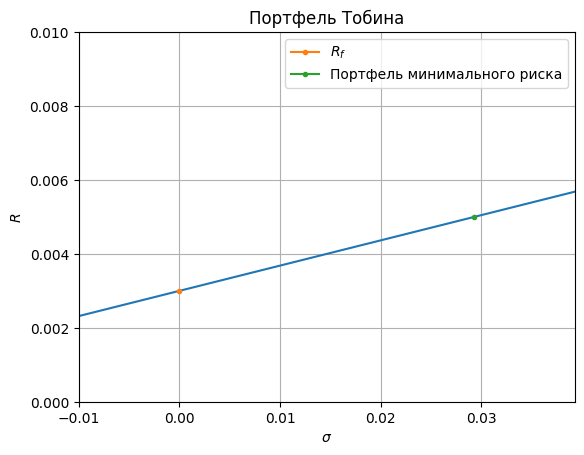

In [300]:
r_f = 0.003
TobinsModel(r_f, r_p, sigm_p)

# Портфель шарпа

# Скачиваем данные с мос биржы

In [301]:
df = pd.read_excel('dataMos.xlsx')
df = df.set_index('<DATE>')
df.head(10)


,<TICKER>,<CLOSE>
<DATE>,,
2022-04-25,IMOEX,2445.17
2022-05-02,IMOEX,2393.03
2022-05-09,IMOEX,2307.50
2022-05-16,IMOEX,2373.26
2022-05-23,IMOEX,2407.59
2022-05-30,IMOEX,2308.03
2022-06-06,IMOEX,2285.52
2022-06-13,IMOEX,2353.98
2022-06-20,IMOEX,2391.51


In [302]:
# считаем стандартное отклонение
sigma_sqrt = df['<CLOSE>'].pct_change().std() ** 2  #
beta = []
r = changes.fillna(0).to_numpy()
r_m = df['<CLOSE>'].pct_change().fillna(0).to_numpy()


# Cсчитаем ковариацию
for i in range(r.shape[1]):
    cov = np.cov(r[:, i], r_m)
    beta.append(cov[1][0] / sigma_sqrt)
 
print(beta)

parametrs['beta'] = beta

parametrs

[0.9450695167015877, 0.3210237940371079, 0.933240118819168]


,Акция,E(R),sigma(R),Вес,beta
1,LKOH,0.006009,0.041397,0.375313,0.945070
2,ARFLT,0.003654,0.041155,0.400232,0.321024
3,YNDX,0.005703,0.048042,0.224829,0.933240


# Лабораторная работа № 2 

In [303]:
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split


# читаем данные из эксель
df = pd.read_excel('stockdata.xlsx')
df = df.set_index('DATE')
df.head(10)

# Создаем модель для линейной регресии

df_new = pd.DataFrame({'data': df['LKOH']}) 
df_new = df_new.reset_index()
df_new = df_new.drop(columns='DATE')
df_new = df_new.reset_index()
df_new



model = linear_model.LinearRegression()


# Разделяем тестовую и тренировучную выборку данных

In [304]:

x_train, x_test, y_train, y_test = train_test_split(df_new['index'].to_numpy().reshape(-1, 1), df_new['data'].to_numpy().reshape(-1, 1), test_size=0.3, random_state=42)
# Заполняем модель

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f"Точность модели:", model.score(y_test, y_pred))
print(f"Кожфиценты модели:", model.coef_, model.intercept_)


# Счаитаем шумы
df_new['eps'] = df_new['data'] - (model.intercept_ + model.coef_[0] * df_new['index'])
df_new['eps']


Точность модели: -42858.786940635946
Кожфиценты модели: [[38.84381801]] [3330.20239928]


0     1369.297601
1     1266.453783
2      972.109965
3      832.266147
4      804.422329
         ...     
79     839.135978
80     850.792160
81     748.948342
82     779.604524
83     647.760706
Name: eps, Length: 84, dtype: float64

In [305]:
# считаем эпсилон за прошлую неделю
df_new['shift_eps_1'] = df_new['eps'].shift(1)
df_new['shift_eps_1']

0             NaN
1     1369.297601
2     1266.453783
3      972.109965
4      832.266147
         ...     
79     957.979796
80     839.135978
81     850.792160
82     748.948342
83     779.604524
Name: shift_eps_1, Length: 84, dtype: float64

# стороим матрицу коваариации и берем коэффицент

In [306]:


corr_matrix = df_new.iloc[:, 2:].corr()
corr = corr_matrix.iloc[0, 1]
print("Ковариация:", corr)

df_new


Ковариация: 0.9518830271633539


,index,data,eps,shift_eps_1
0,0,4699.5,1369.297601,NaN
1,1,4635.5,1266.453783,1369.297601
2,2,4380.0,972.109965,1266.453783
3,3,4279.0,832.266147,972.109965
4,4,4290.0,804.422329,832.266147
...,...,...,...,...
79,79,7238.0,839.135978,957.979796
80,80,7288.5,850.792160,839.135978
81,81,7225.5,748.948342,850.792160
82,82,7295.0,779.604524,748.948342


In [307]:
#Пересчитываем учитывая кореляцию
df_new['eps^'] = df_new['eps'] * corr
df_new['eps^'] = df_new['eps^'].shift(1)




In [308]:
# считаем разницу
df_new = df_new.fillna(0)
df_new['e'] = df_new['eps'] - df_new['eps^']


# Пересчитваем предсказание модели

In [309]:

df_new['prdeict'] = df_new['eps^'] + (model.intercept_ + model.coef_[0] * df_new['index'])
df_new

,index,data,eps,shift_eps_1,eps^,e,prdeict
0,0,4699.5,1369.297601,0.000000,0.000000,1369.297601,3330.202399
1,1,4635.5,1266.453783,1369.297601,1303.411145,-36.957363,4672.457363
2,2,4380.0,972.109965,1266.453783,1205.515860,-233.405896,4613.405896
3,3,4279.0,832.266147,972.109965,925.334976,-93.068829,4372.068829
4,4,4290.0,804.422329,832.266147,792.220019,12.202310,4277.797690
...,...,...,...,...,...,...,...
79,79,7238.0,839.135978,957.979796,911.884708,-72.748730,7310.748730
80,80,7288.5,850.792160,839.135978,798.759295,52.032865,7236.467135
81,81,7225.5,748.948342,850.792160,809.854617,-60.906275,7286.406275
82,82,7295.0,779.604524,748.948342,712.911215,66.693309,7228.306691


# делаем предсказание на новые 17 недель

In [310]:

prev_eps_with_cow = df_new['eps^'].iloc[83]
prev_eps = df_new['eps'].iloc[83]

for i in range(17):
    #print(model.intercept_ + model.coef_[0] + prev_eps_with_cow - prev_eps_with_cow * corr)
    df_new.loc[84 + i] = [84 + i, 0, prev_eps_with_cow, 0, prev_eps * corr, prev_eps - prev_eps * corr, (model.intercept_ + model.coef_[0] * (84 + i) + prev_eps * corr)[0]]
    prev_eps = df_new['eps'].iloc[84 + i]
    prev_eps_with_cow = df_new['eps^'].iloc[84 + i]
    
df_new

,index,data,eps,shift_eps_1,eps^,e,prdeict
0,0.0,4699.5,1369.297601,0.000000,0.000000,1369.297601,3330.202399
1,1.0,4635.5,1266.453783,1369.297601,1303.411145,-36.957363,4672.457363
2,2.0,4380.0,972.109965,1266.453783,1205.515860,-233.405896,4613.405896
3,3.0,4279.0,832.266147,972.109965,925.334976,-93.068829,4372.068829
4,4.0,4290.0,804.422329,832.266147,792.220019,12.202310,4277.797690
...,...,...,...,...,...,...,...
96,96.0,0.0,552.025872,0.000000,458.669309,23.185389,7517.878237
97,97.0,0.0,458.669309,0.000000,525.464058,26.561814,7623.516804
98,98.0,0.0,525.464058,0.000000,436.599530,22.069779,7573.496094
99,99.0,0.0,436.599530,0.000000,500.180318,25.283740,7675.920700


# достаем данные для сравнения

In [311]:

df_final = pd.DataFrame({'data': df_new['data'], 'predict': df_new['prdeict']})
df_final


,data,predict
0,4699.5,3330.202399
1,4635.5,4672.457363
2,4380.0,4613.405896
3,4279.0,4372.068829
4,4290.0,4277.797690
...,...,...
96,0.0,7517.878237
97,0.0,7623.516804
98,0.0,7573.496094
99,0.0,7675.920700


# строим график акции лукойла

In [312]:
px.line(df_final)



# строим регресиию второго уровня

In [313]:


df_new_second_op = df_new


df_new_second_op['eps_shift_2'] = df_new_second_op['eps'].shift(2)

df_new_second_op

,index,data,eps,shift_eps_1,eps^,e,prdeict,eps_shift_2
0,0.0,4699.5,1369.297601,0.000000,0.000000,1369.297601,3330.202399,NaN
1,1.0,4635.5,1266.453783,1369.297601,1303.411145,-36.957363,4672.457363,NaN
2,2.0,4380.0,972.109965,1266.453783,1205.515860,-233.405896,4613.405896,1369.297601
3,3.0,4279.0,832.266147,972.109965,925.334976,-93.068829,4372.068829,1266.453783
4,4.0,4290.0,804.422329,832.266147,792.220019,12.202310,4277.797690,972.109965
...,...,...,...,...,...,...,...,...
96,96.0,0.0,552.025872,0.000000,458.669309,23.185389,7517.878237,579.930365
97,97.0,0.0,458.669309,0.000000,525.464058,26.561814,7623.516804,481.854699
98,98.0,0.0,525.464058,0.000000,436.599530,22.069779,7573.496094,552.025872
99,99.0,0.0,436.599530,0.000000,500.180318,25.283740,7675.920700,458.669309


# считаем ковариацию

In [314]:


corr_matrix = df_new.loc[:, ['eps', 'shift_eps_1', 'eps_shift_2']].corr()
corr_eps_1 = corr_matrix.iloc[0, 1]
corr_eps_2 = corr_matrix.iloc[0, 2]
print("Ковариация", corr_eps_1, corr_eps_2)



Ковариация 0.8671386169514331 0.9072605164604925


# считаем альфу 1 и 2

In [315]:

alpha1 = (corr_eps_1 - (1 - corr_eps_2)) / (corr_eps_1 ** 2)
alpha2 = (corr_eps_2 - corr_eps_1 ** 2) / (corr_eps_1 ** 2)
print("Alpha1, Alpha2 :", alpha1, alpha2)


df_new['eps^^'] = df_new['shift_eps_1'] * alpha2 + df_new['eps_shift_2'] * alpha1
df_new

Alpha1, Alpha2 : 1.0298827961388426 0.20657676023209398


,index,data,eps,shift_eps_1,eps^,e,prdeict,eps_shift_2,eps^^
0,0.0,4699.5,1369.297601,0.000000,0.000000,1369.297601,3330.202399,NaN,NaN
1,1.0,4635.5,1266.453783,1369.297601,1303.411145,-36.957363,4672.457363,NaN,NaN
2,2.0,4380.0,972.109965,1266.453783,1205.515860,-233.405896,4613.405896,1369.297601,1671.835961
3,3.0,4279.0,832.266147,972.109965,925.334976,-93.068829,4372.068829,1266.453783,1505.114290
4,4.0,4290.0,804.422329,832.266147,792.220019,12.202310,4277.797690,972.109965,1173.086173
...,...,...,...,...,...,...,...,...,...
96,96.0,0.0,552.025872,0.000000,458.669309,23.185389,7517.878237,579.930365,597.260306
97,97.0,0.0,458.669309,0.000000,525.464058,26.561814,7623.516804,481.854699,496.253864
98,98.0,0.0,525.464058,0.000000,436.599530,22.069779,7573.496094,552.025872,568.521948
99,99.0,0.0,436.599530,0.000000,500.180318,25.283740,7675.920700,458.669309,472.375631


In [316]:
df_new = df_new.fillna(0)
df_new['e'] = df_new['eps'] - df_new['eps^^']

In [317]:
df_new['prdeict_2'] = (model.intercept_ + model.coef_[0] * df_new['index'] + df_new['eps^^'])
df_new

,index,data,eps,shift_eps_1,eps^,e,prdeict,eps_shift_2,eps^^,prdeict_2
0,0.0,4699.5,1369.297601,0.000000,0.000000,1369.297601,3330.202399,0.000000,0.000000,3330.202399
1,1.0,4635.5,1266.453783,1369.297601,1303.411145,1266.453783,4672.457363,0.000000,0.000000,3369.046217
2,2.0,4380.0,972.109965,1266.453783,1205.515860,-699.725996,4613.405896,1369.297601,1671.835961,5079.725996
3,3.0,4279.0,832.266147,972.109965,925.334976,-672.848143,4372.068829,1266.453783,1505.114290,4951.848143
4,4.0,4290.0,804.422329,832.266147,792.220019,-368.663844,4277.797690,972.109965,1173.086173,4658.663844
...,...,...,...,...,...,...,...,...,...,...
96,96.0,0.0,552.025872,0.000000,458.669309,-45.234435,7517.878237,579.930365,597.260306,7656.469234
97,97.0,0.0,458.669309,0.000000,525.464058,-37.584555,7623.516804,481.854699,496.253864,7594.306610
98,98.0,0.0,525.464058,0.000000,436.599530,-43.057890,7573.496094,552.025872,568.521948,7705.418512
99,99.0,0.0,436.599530,0.000000,500.180318,-35.776100,7675.920700,458.669309,472.375631,7648.116013


# строим предсказание на 17 недель

In [318]:
prev_eps = df_new['eps'].iloc[83]
prev_prev_eps = df_new['eps'].iloc[82]
 
prev_prev_eps_with_two_cows = df_new['eps^^'].iloc[83]

for i in range(17):
    #print(model.intercept_ + model.coef_[0] + prev_eps - prev_eps * corr)
    df_new.loc[84 + i] = [84 + i, 0, prev_prev_eps_with_two_cows, prev_eps, 0, prev_prev_eps_with_two_cows  - prev_eps * alpha2 + prev_prev_eps * alpha1, 0, prev_prev_eps, prev_eps * alpha1 + prev_prev_eps  * alpha2, (model.intercept_ + model.coef_[0] * (84 + i) + prev_eps * alpha1 + prev_prev_eps  * alpha2)[0]]
    prev_eps = df_new['eps'].iloc[84 + i]
    prev_prev_eps = df_new['eps'].iloc[83 + i]
    prev_prev_eps_with_two_cows = df_new['eps^^'].iloc[83 + i]
    
    
df_new

,index,data,eps,shift_eps_1,eps^,e,prdeict,eps_shift_2,eps^^,prdeict_2
0,0.0,4699.5,1369.297601,0.000000,0.000000,1369.297601,3330.202399,0.000000,0.000000,3330.202399
1,1.0,4635.5,1266.453783,1369.297601,1303.411145,1266.453783,4672.457363,0.000000,0.000000,3369.046217
2,2.0,4380.0,972.109965,1266.453783,1205.515860,-699.725996,4613.405896,1369.297601,1671.835961,5079.725996
3,3.0,4279.0,832.266147,972.109965,925.334976,-672.848143,4372.068829,1266.453783,1505.114290,4951.848143
4,4.0,4290.0,804.422329,832.266147,792.220019,-368.663844,4277.797690,972.109965,1173.086173,4658.663844
...,...,...,...,...,...,...,...,...,...,...
96,96.0,0.0,1870.614322,1646.164406,0.000000,3305.698526,0.000000,1723.636437,2051.419633,9110.628561
97,97.0,0.0,2095.872042,1870.614322,0.000000,3404.802998,0.000000,1646.164406,2266.572819,9364.625565
98,98.0,0.0,2051.419633,2095.872042,0.000000,3544.974685,0.000000,1870.614322,2544.928006,9681.824570
99,99.0,0.0,2266.572819,2051.419633,0.000000,4001.299757,0.000000,2095.872042,2545.680244,9721.420626


In [319]:
df_final = pd.DataFrame({'data': df_new['data'], 'predict': df_new['prdeict_2']})
df_final


,data,predict
0,4699.5,3330.202399
1,4635.5,3369.046217
2,4380.0,5079.725996
3,4279.0,4951.848143
4,4290.0,4658.663844
...,...,...
96,0.0,9110.628561
97,0.0,9364.625565
98,0.0,9681.824570
99,0.0,9721.420626


# строим график с учетом предсказания

In [320]:
px.line(df_final)


# Лабороторная работа №3

# Скачиваем данные из excel

In [321]:

df3 = pd.read_excel('stockdata.xlsx')

df3 = df3.set_index('DATE')
df3

,LKOH,ARFLT,YNDX
DATE,,,
2022-04-25,4699.5,30.50,1766.6
2022-05-02,4635.5,32.14,1688.0
2022-05-09,4380.0,29.98,1593.0
2022-05-16,4279.0,29.28,1646.0
2022-05-23,4290.0,29.42,1644.0
...,...,...,...
2023-10-30,7238.0,40.07,2613.0
2023-11-06,7288.5,38.98,2598.8
2023-11-13,7225.5,39.21,2572.0


# Считаем и вычитаем среднее

In [322]:
mean1 = df3['YNDX'].mean()
df3['YNDX'] = df3['YNDX'] - mean1
mean1 = df3['ARFLT'].mean()
df3['ARFLT'] = df3['ARFLT'] - mean1
mean1 = df3['LKOH'].mean()
df3['LKOH'] = df3['LKOH'] - mean1
df3

,LKOH,ARFLT,YNDX
DATE,,,
2022-04-25,-238.839286,-2.257381,-343.995238
2022-05-02,-302.839286,-0.617381,-422.595238
2022-05-09,-558.339286,-2.777381,-517.595238
2022-05-16,-659.339286,-3.477381,-464.595238
2022-05-23,-648.339286,-3.337381,-466.595238
...,...,...,...
2023-10-30,2299.660714,7.312619,502.404762
2023-11-06,2350.160714,6.222619,488.204762
2023-11-13,2287.160714,6.452619,461.404762


# Считаем стандартное отклонение

In [323]:
std1 = df3['YNDX'].std()
df3['YNDX'] = df3['YNDX'] / std1
std1 = df3['ARFLT'].std()
df3['ARFLT'] = df3['ARFLT'] / std1
std1 = df3['LKOH'].std()
df3['LKOH'] = df3['LKOH'] / std1
df3

,LKOH,ARFLT,YNDX
DATE,,,
2022-04-25,-0.211953,-0.312791,-0.984899
2022-05-02,-0.268748,-0.085547,-1.209940
2022-05-09,-0.495486,-0.384844,-1.481936
2022-05-16,-0.585116,-0.481839,-1.330191
2022-05-23,-0.575354,-0.462440,-1.335917
...,...,...,...
2023-10-30,2.040782,1.013264,1.438444
2023-11-06,2.085597,0.862229,1.397787
2023-11-13,2.029689,0.894099,1.321056


# строим матрицу ковариаций

In [324]:
cov = df3.cov()
print(cov)

           LKOH     ARFLT      YNDX
LKOH   1.000000  0.803867  0.857004
ARFLT  0.803867  1.000000  0.822800
YNDX   0.857004  0.822800  1.000000


![image][def]

[def]: lab3.png

# Получаем массив индекса рынка

In [325]:
Atranspose = (df3.to_numpy()).T

v = np.array([0.933, 0.978, 1])

result = np.dot(v, Atranspose)
print(result)

[-1.48856012 -1.54434601 -2.32060158 -2.34734208 -2.3249885  -3.09156349
 -3.70904388 -3.34971509 -2.73691882 -3.1039459  -2.81121104 -3.06271713
 -2.6911757  -2.02631733 -2.50554829 -2.25768025 -2.05679957 -1.50037994
 -0.76194615 -0.6654589  -0.37724475 -2.22793641 -2.44292321 -2.68123617
 -2.47558581 -2.05828486 -1.57015682 -1.14855193 -1.12907268 -1.23941238
 -1.5108061  -1.7680853  -1.83678865 -2.17364601 -2.7618725  -2.70920534
 -2.54280586 -2.2650245  -2.08158971 -2.08062014 -1.67947994 -1.65628308
 -1.82638303 -1.91144766 -1.7541806  -1.87164433 -1.90139205 -1.82342339
 -1.48962622 -0.96616335 -0.72002274  0.04660629  0.50216749  0.22010368
  0.20332707  1.19498005  1.75185903  2.05065048  2.23416641  2.5220961
  2.3346095   2.2106774   2.48972166  2.93512681  2.96617022  3.84921522
  4.38475154  4.5436712   4.31359515  4.53895649  4.78622932  4.17802323
  3.95321665  3.35040287  3.38874831  3.80117357  4.12008918  4.78360748
  4.67106449  4.33346548  4.18690995  4.08918485  4.

In [326]:
df3result = pd.DataFrame({'date' : df3.index, 'value': result })
df3result = df3result.set_index('date')
df3result

,value
date,
2022-04-25,-1.488560
2022-05-02,-1.544346
2022-05-09,-2.320602
2022-05-16,-2.347342
2022-05-23,-2.324988
...,...
2023-10-30,4.333465
2023-11-06,4.186910
2023-11-13,4.089185


# График индекса рынка

In [327]:
px.line(df3result)